# Hidden Markov Models

A Hidden Markov Model (HMM) is a probabilistic model for sequential data that assumes the existence of a latent variable ${\bf z}$ that forms a Markov Chain with previous latent variables samplez

![hmm](https://imgur.com/1YC0iu0.png)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Sampling from an HMM

In [3]:
initial_probs = np.array([0.3, 0.2, 0.5])

# transition matrix
A = np.array([
    [0.3, 0.4, 0.3],
    [0.1, 0.6, 0.3],
    [0.2, 0.3, 0.5]
])

In [4]:
S1 = np.array([
    [1.1, 0],
    [0, 0.3]
])

S2 = np.array([
    [0.3, -0.5],
    [-0.5, 1.3]
])

S3 = np.array([
    [0.8, 0.4],
    [0.4, 0.5]
])


mu_collection = np.array([
    [0.3, 0.3],
    [0.8, 0.5],
    [0.3, 0.8]
])

cov_collection = np.array([S1, S2, S3]) / 60

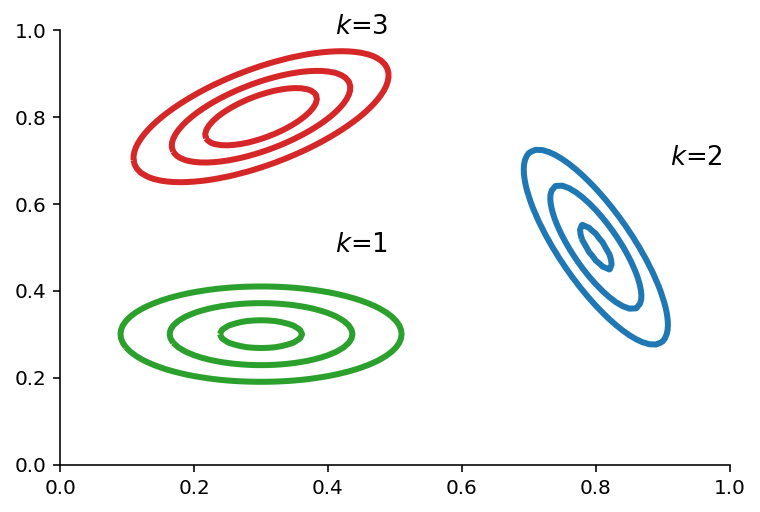

In [5]:
Xgrid = np.mgrid[0:1:0.01, 0:1:0.01]
colors = ["tab:green", "tab:blue", "tab:red"]

for k, (mu, S, color) in enumerate(zip(mu_collection, cov_collection, colors)):
    N = multivariate_normal(mean=mu, cov=S)
    Z = np.apply_along_axis(N.pdf, 0, Xgrid)
    plt.contour(*Xgrid, Z, levels=3, colors=color, linewidths=3)
    plt.text(*(mu + 0.19), f"$k$={k + 1}", fontsize=13, horizontalalignment="right")
plt.xlim(0, 1)
plt.ylim(0, 1);

### The sampling

In [6]:
np.random.seed(314)
z = np.array([0, 1, 2])
# Choose an initial latent variable Z1
z1 = np.random.choice(z, p=initial_probs)
# Sample the corresponding observation x1
N = multivariate_normal(mu_collection[z1], cov_collection[z1])
x1 = N.rvs()
# Choose the state of the variable z2 according to the
# transition probabilities p(z2|z1)
z2 = np.random.choice(z, p=A[z1])
# Once we know z2, we can sample x2 and so on
N = multivariate_normal(mu_collection[z2], cov_collection[z2])
x2 = N.rvs()
# ...

In [7]:
# ==All together==
np.random.seed(314)
n_samples = 50
z = np.array([0, 1, 2])

# Initial latent variable
zi = np.random.choice(z, p=initial_probs)

samples = np.zeros((n_samples, 2))
color_samples = []

for i in range(n_samples):
    N = multivariate_normal(mu_collection[zi], cov_collection[zi])
    samples[i] = N.rvs()
    
    color = colors[zi]
    color_samples.append(color)
    
    zi = np.random.choice(z, p=A[zi])
    

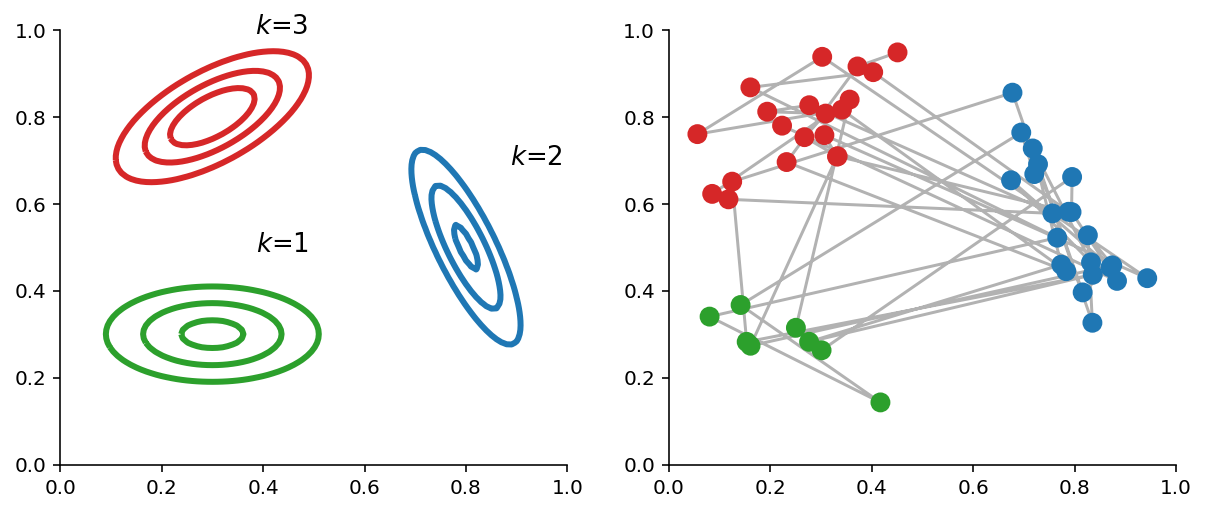

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

Xgrid = np.mgrid[0:1:0.01, 0:1:0.01]
colors = ["tab:green", "tab:blue", "tab:red"]

for k, (mu, S, color) in enumerate(zip(mu_collection, cov_collection, colors)):
    N = multivariate_normal(mean=mu, cov=S)
    Z = np.apply_along_axis(N.pdf, 0, Xgrid)
    ax[0].contour(*Xgrid, Z, levels=3, colors=color, linewidths=3)
    ax[0].text(*(mu + 0.19), f"$k$={k + 1}", fontsize=13, horizontalalignment="right")
    
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)


ax[1].plot(*samples.T, c="black", alpha=0.3, zorder=1)
ax[1].scatter(*samples.T, c=color_samples, s=80, zorder=2);
plt.savefig("/Users/gerardoduran/Desktop/HMM.png", dpi=200)

---

## Maximum Likelihood for the HMM

The likelihood function for an HMM is given by

$$
\begin{aligned}
    p({\bf X} \vert \boldsymbol\theta) &= \sum_{{\bf Z}} p({\bf X}, {\bf Z} \vert \boldsymbol\theta) \\
    &= \sum_{\bf Z} p({\bf Z}\vert \boldsymbol\pi, {\bf A})p({\bf X}\vert {\bf Z}, \boldsymbol\phi) \\
    &= \sum_{{\bf z}_1, \ldots, {\bf z}_N} \left[p({\bf z}_1\vert\boldsymbol\pi) \prod_{n=1}^N p({\bf z}_n\vert {\bf z}_{n-1}, {\bf A})\prod_{m=1}^Np({\bf x}_m\vert {\bf z}_m, \boldsymbol\phi)\right]
\end{aligned}
$$

Note that
1. The joint distribution of the likelihood does not factorize over $n$;
2. summations over ${\bf z}_n$ are not independent;
3. **it is computationally intractable to perform summations explicitly**

To further understand 3., consider that the summation of the likelihood considers $N$ variables, each of which has $K$ states. Hence, we would need to perform $K^N$ summations. To illustrate this point, the following table considers different scenarios for $K$ and $N$.

In [46]:
N = np.array([[1, 10, 100, 250]], dtype=np.float128).T
K = np.array([[1, 2, 3, 5, 10, 12]], dtype=np.float128).T

# (Observations, States)
pd.DataFrame(np.power(K, N.T), index=K.ravel(), columns=N.ravel())

,1.0,10.0,100.0,250.0
1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
2.0,2.0,1.024000e+03,1.267651e+30,1.809251e+75
3.0,3.0,5.904900e+04,5.153775e+47,1.906837e+119
5.0,5.0,9.765625e+06,7.888609e+69,5.527148e+174
10.0,10.0,1.000000e+10,1.000000e+100,1.000000e+250
12.0,12.0,6.191736e+10,8.281797e+107,6.241824e+269


> The number of terms in the summation [of the maximum likelihood] grows exponentially with the lenght of the chain